# 2.5 - Autoencoders

Course's material requires a `tensorflow` version lower than the default one used in Google Colab. Run the following cell to downgrade TensorFlow accordingly.

In [ ]:
import os
def downgrade_tf_version():
    os.system("!yes | pip uninstall -y tensorflow")
    os.system("!yes | pip install tensorflow==2.12.0")
    os.kill(os.getpid(), 9)
downgrade_tf_version()

In [1]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False); 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

## 1. Introduction

An autoencoder is an unsupervised lerarning method in which we seek to obtain a **LATENT REPRESENTATION** of our data, usually with reduced dimensionality.



We will be using 

- **Tensorflow**. Since TF can use GPUs or TPUs if available, it is usually better to force all data types to be `np.float32` or `int`.

- The **MNIST** digits classification dataset. Observe how **we normalize** the MNIST images.

In [12]:
mnist = pd.read_csv("local/data/mnist1.5k.csv.gz", compression="gzip", header=None).values
X=(mnist[:,1:785]/255.).astype(np.float32)
y=(mnist[:,0]).astype(int)
print("dimension de las imagenes y las clases", X.shape, y.shape)

dimension de las imagenes y las clases (1500, 784) (1500,)


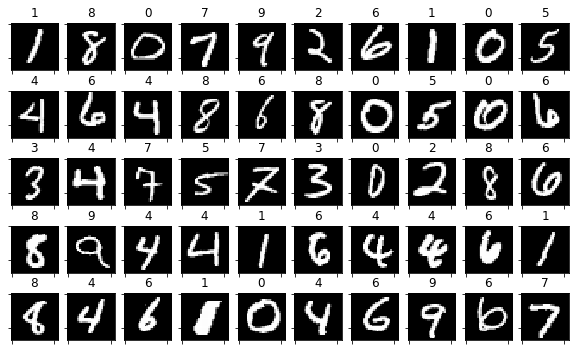

In [13]:
perm = np.random.permutation(list(range(X.shape[0])))[0:50]
random_imgs   = X[perm]
random_labels = y[perm] 
fig = plt.figure(figsize=(10,6))
for i in range(random_imgs.shape[0]):
    ax=fig.add_subplot(5,10,i+1)
    plt.imshow(random_imgs[i].reshape(28,28), interpolation="nearest", cmap = plt.cm.Greys_r)
    ax.set_title(int(random_labels[i]))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

and we do the regular train/test split

In [121]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

## 2. Assembling and training an autoencoder

Observe how an autoencoder is just a concatenation of two regular `Dense` layers. **Why are we using a sigmoid as decoder output activation?**

In [124]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
import tensorflow as tf

In [125]:
def get_model(input_dim, code_size):

    inputs = Input(shape=input_dim, name="input")
    encoder = Dense(code_size, activation='relu', dtype=np.float32, name="encoder")(inputs)
    outputs = Dense(input_dim, activation='sigmoid', dtype=np.float32, name="decoder")(encoder)

    model = Model([inputs], [outputs])
    model.compile(optimizer='adam', loss='mse')
    return model

In [119]:
model = get_model(input_dim=X.shape[1], code_size=50)
model.summary()

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
encoder (Dense)              (None, 50)                39250     
_________________________________________________________________
decoder (Dense)              (None, 784)               39984     
Total params: 79,234
Trainable params: 79,234
Non-trainable params: 0
_________________________________________________________________


and we simply train the autoencoder. Observe how we use the same data as input and output

In [120]:
model.fit(X_train, X_train, epochs=100, batch_size=16)

Train on 1200 samples
Epoch 1/100
1200/1200 [==============================] - 0s 219us/sample - loss: 0.1047
Epoch 2/100
1200/1200 [==============================] - 0s 80us/sample - loss: 0.0597
Epoch 3/100
1200/1200 [==============================] - 0s 84us/sample - loss: 0.0493
Epoch 4/100
1200/1200 [==============================] - 0s 86us/sample - loss: 0.0427
Epoch 5/100
1200/1200 [==============================] - 0s 83us/sample - loss: 0.0380
Epoch 6/100
1200/1200 [==============================] - 0s 82us/sample - loss: 0.0344
Epoch 7/100
1200/1200 [==============================] - 0s 81us/sample - loss: 0.0314
Epoch 8/100
1200/1200 [==============================] - 0s 81us/sample - loss: 0.0290
Epoch 9/100
1200/1200 [==============================] - 0s 81us/sample - loss: 0.0269
Epoch 10/100
1200/1200 [==============================] - 0s 82us/sample - loss: 0.0251
Epoch 11/100
1200/1200 [==============================] - 0s 93us/sample - loss: 0.0234
Epoch 12/100
1200/

Epoch 94/100
1200/1200 [==============================] - 0s 54us/sample - loss: 0.0044
Epoch 95/100
1200/1200 [==============================] - 0s 62us/sample - loss: 0.0044
Epoch 96/100
1200/1200 [==============================] - 0s 65us/sample - loss: 0.0043
Epoch 97/100
1200/1200 [==============================] - 0s 63us/sample - loss: 0.0043
Epoch 98/100
1200/1200 [==============================] - 0s 60us/sample - loss: 0.0043
Epoch 99/100
1200/1200 [==============================] - 0s 58us/sample - loss: 0.0043
Epoch 100/100
1200/1200 [==============================] - 0s 59us/sample - loss: 0.0043


The training seems to have gone well (the loss was reduced)

**Question**: How can we measure how **_good_** was the result?

You can try with larger layers, with more layers, etc.

### Making predictions

We can feed the model any input and get the output. Observe we **get eager tensors**, which are like a symbolic wrapper to numpy matrices. We will see more about this later in this course. 

In [60]:
o = model(X_train)
o

<tf.Tensor: shape=(1200, 784), dtype=float32, numpy=
array([[3.6984453e-08, 1.9736575e-10, 2.5541331e-09, ..., 3.9784051e-10,
        2.2014549e-10, 1.1092759e-09],
       [2.4385532e-08, 5.4472249e-08, 1.0746028e-07, ..., 3.1418881e-07,
        3.5111746e-08, 4.8708703e-08],
       [6.5164496e-09, 9.6711994e-10, 2.4460364e-10, ..., 3.5345697e-09,
        1.6141123e-10, 6.1249552e-09],
       ...,
       [7.9344659e-07, 8.7452588e-07, 8.2074229e-07, ..., 2.4234178e-06,
        9.3258961e-07, 5.6553978e-07],
       [9.9626490e-08, 6.0966705e-08, 8.2821021e-09, ..., 1.4567654e-08,
        1.0074373e-08, 6.9440011e-07],
       [5.3350539e-07, 3.4182764e-07, 1.0137308e-06, ..., 3.1523388e-07,
        5.7831215e-08, 2.0375307e-07]], dtype=float32)>

in eager tensors we can access the underlying `numpy` matrix.

In [61]:
o.numpy()

array([[3.6984453e-08, 1.9736575e-10, 2.5541331e-09, ..., 3.9784051e-10,
        2.2014549e-10, 1.1092759e-09],
       [2.4385532e-08, 5.4472249e-08, 1.0746028e-07, ..., 3.1418881e-07,
        3.5111746e-08, 4.8708703e-08],
       [6.5164496e-09, 9.6711994e-10, 2.4460364e-10, ..., 3.5345697e-09,
        1.6141123e-10, 6.1249552e-09],
       ...,
       [7.9344659e-07, 8.7452588e-07, 8.2074229e-07, ..., 2.4234178e-06,
        9.3258961e-07, 5.6553978e-07],
       [9.9626490e-08, 6.0966705e-08, 8.2821021e-09, ..., 1.4567654e-08,
        1.0074373e-08, 6.9440011e-07],
       [5.3350539e-07, 3.4182764e-07, 1.0137308e-06, ..., 3.1523388e-07,
        5.7831215e-08, 2.0375307e-07]], dtype=float32)

which is equivalent to using the `predict` method

In [151]:
model.predict(X_train)

array([[8.51090044e-06, 9.57351585e-06, 1.13940905e-05, ...,
        3.42914391e-05, 3.14637837e-05, 2.88015835e-05],
       [1.86773832e-07, 1.27578161e-07, 1.07958464e-07, ...,
        1.01204898e-06, 2.39109053e-08, 8.60198028e-08],
       [3.13102419e-07, 1.51896174e-07, 9.71393774e-07, ...,
        2.90563321e-07, 1.50165334e-07, 1.02712795e-06],
       ...,
       [5.47624950e-06, 1.08655540e-05, 3.28201281e-06, ...,
        1.65009769e-05, 3.28613760e-06, 6.86891599e-06],
       [1.78545015e-05, 3.65451124e-05, 1.01834385e-05, ...,
        3.14925092e-05, 9.99619442e-06, 3.84393861e-05],
       [1.01194764e-05, 1.31769011e-05, 3.37959609e-05, ...,
        2.97471677e-04, 3.17740560e-05, 5.00498973e-05]], dtype=float32)

In [105]:
X_sample = np.random.permutation(X_test)[:10]
X_pred   = model.predict(X_sample)

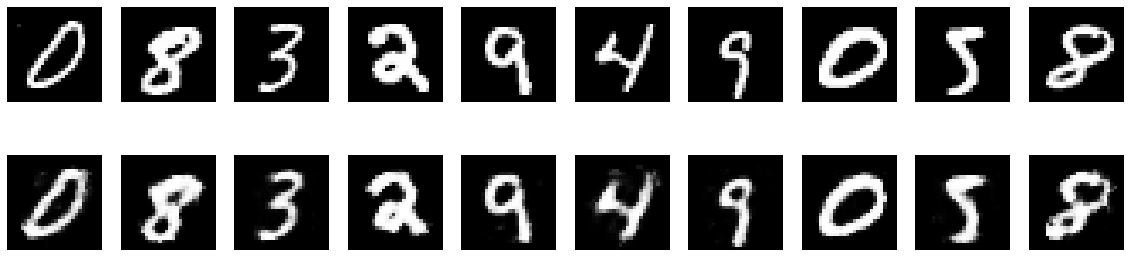

In [106]:
plt.figure(figsize=(20,5))
for i in range(len(X_sample)):
    plt.subplot(2,len(X_sample),i+1)
    plt.imshow(X_sample[i].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.subplot(2,len(X_sample),len(X_sample)+i+1)
    plt.imshow(X_pred[i].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")

### Accessing model layers

We can also get the output of any layer, including the final layer

In [128]:
layer_input   = model.get_layer("input")
layer_encoder = model.get_layer("encoder")
layer_decoder = model.get_layer("decoder")

m = Model([layer_input.input], [layer_decoder.output])
m(X_train)

<tf.Tensor: shape=(1200, 784), dtype=float32, numpy=
array([[8.51090044e-06, 9.57351585e-06, 1.13941014e-05, ...,
        3.42914718e-05, 3.14638128e-05, 2.88015835e-05],
       [1.86773661e-07, 1.27578161e-07, 1.07958464e-07, ...,
        1.01204989e-06, 2.39109053e-08, 8.60198028e-08],
       [3.13102760e-07, 1.51896316e-07, 9.71393774e-07, ...,
        2.90563577e-07, 1.50165334e-07, 1.02712988e-06],
       ...,
       [5.47624950e-06, 1.08655540e-05, 3.28200645e-06, ...,
        1.65009933e-05, 3.28613760e-06, 6.86891599e-06],
       [1.78545015e-05, 3.65451488e-05, 1.01834385e-05, ...,
        3.14925092e-05, 9.99619442e-06, 3.84393861e-05],
       [1.01194764e-05, 1.31769148e-05, 3.37959900e-05, ...,
        2.97471968e-04, 3.17740851e-05, 5.00498973e-05]], dtype=float32)>

of the encoder, shapes must match

In [129]:
me = Model([layer_input.input], [layer_encoder.output])
me(X_train)

<tf.Tensor: shape=(1200, 50), dtype=float32, numpy=
array([[ 1.4733481 ,  5.6071835 ,  0.4546271 , ...,  6.584404  ,
         0.        ,  3.4143682 ],
       [ 5.7947493 ,  6.376433  ,  0.        , ...,  1.1779828 ,
         1.8339571 ,  2.2694755 ],
       [ 1.7550068 ,  4.7390604 ,  0.64162546, ...,  8.171952  ,
         4.2970653 ,  1.2317356 ],
       ...,
       [ 5.9646645 ,  6.6686645 ,  3.091914  , ...,  1.5258911 ,
         2.0375972 ,  8.356914  ],
       [ 3.3050153 ,  4.8892    ,  4.8872223 , ...,  2.1351342 ,
         4.004214  ,  7.943392  ],
       [ 5.2594194 ,  3.1832466 ,  1.4421158 , ...,  4.5179844 ,
        12.360394  ,  3.8473024 ]], dtype=float32)>

### Accessing model weights

recall that these are the weights adjusted during training

In [145]:
w = model.get_weights()
for i, wi in enumerate(w):
    print (f"weights {i}: {str(wi.shape):10s} sum {np.sum(wi):+6.2f}")

weights 0: (784, 50)  sum +1014.07
weights 1: (50,)      sum +24.43
weights 2: (50, 784)  sum -1458.86
weights 3: (784,)     sum -181.90


the same weights can also we accessed via the layers

In [159]:
for i, li in enumerate(model.layers):
    print ("layer", i, ", ".join([(str(wi.shape)+" sum %+6.2f"%(np.sum(wi.numpy()))) for wi in li.weights]))


layer 0 
layer 1 (784, 50) sum +1014.07, (50,) sum +24.43
layer 2 (50, 784) sum -1458.86, (784,) sum -181.90


In this case, we can also get a visual representation of the weights in the same image space as MNIST. 

Can you tell if the autoencoder "_learnt_" something?

**TRY**: inspect the weights, **BEFORE** and **AFTER** training.

In [171]:
def show_img_grid(w):
    plt.figure(figsize=(6,6))
    for k,wi in enumerate(w):
        plt.subplot(10,10,k+1)
        plt.imshow(wi.reshape(28,28), cmap=plt.cm.Greys_r)
        plt.axis("off")

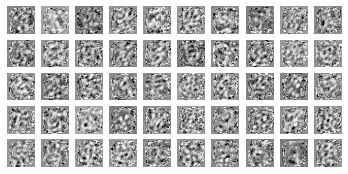

In [172]:
show_img_grid(model.get_layer("encoder").weights[0].numpy().T)

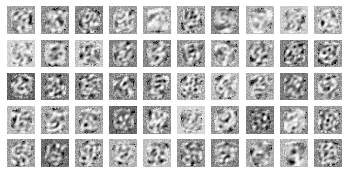

In [173]:
show_img_grid(model.get_layer("decoder").weights[0].numpy())

### Custom feeding data and extracting intermediate activations

TF offers different ways to feed in and out of specific layers. The `tensorflow.keras.backend` offers somewhat more flexiblity.

Observe how we can feed data to our autoencoder and get the activations on the **encoder**.

In [175]:
layer_input   = model.get_layer("input")
layer_encoder = model.get_layer("encoder")

me = Model([layer_input.input], [layer_encoder.output])
me(X_train)

<tf.Tensor: shape=(1200, 50), dtype=float32, numpy=
array([[ 1.4733481 ,  5.6071835 ,  0.4546271 , ...,  6.584404  ,
         0.        ,  3.4143682 ],
       [ 5.7947493 ,  6.376433  ,  0.        , ...,  1.1779828 ,
         1.8339571 ,  2.2694755 ],
       [ 1.7550068 ,  4.7390604 ,  0.64162546, ...,  8.171952  ,
         4.2970653 ,  1.2317356 ],
       ...,
       [ 5.9646645 ,  6.6686645 ,  3.091914  , ...,  1.5258911 ,
         2.0375972 ,  8.356914  ],
       [ 3.3050153 ,  4.8892    ,  4.8872223 , ...,  2.1351342 ,
         4.004214  ,  7.943392  ],
       [ 5.2594194 ,  3.1832466 ,  1.4421158 , ...,  4.5179844 ,
        12.360394  ,  3.8473024 ]], dtype=float32)>

In [176]:
from tensorflow.keras import backend as K
ke = K.function(layer_encoder.input, layer_encoder.output)
ke(X_train)

array([[ 1.4733481 ,  5.6071835 ,  0.4546271 , ...,  6.584404  ,
         0.        ,  3.4143682 ],
       [ 5.7947493 ,  6.376433  ,  0.        , ...,  1.1779828 ,
         1.8339571 ,  2.2694755 ],
       [ 1.7550068 ,  4.7390604 ,  0.64162546, ...,  8.171952  ,
         4.2970653 ,  1.2317356 ],
       ...,
       [ 5.9646645 ,  6.6686645 ,  3.091914  , ...,  1.5258911 ,
         2.0375972 ,  8.356914  ],
       [ 3.3050153 ,  4.8892    ,  4.8872223 , ...,  2.1351342 ,
         4.004214  ,  7.943392  ],
       [ 5.2594194 ,  3.1832466 ,  1.4421158 , ...,  4.5179844 ,
        12.360394  ,  3.8473024 ]], dtype=float32)

## 2. inspecting data in latent space (the encoder)

for one randomly chosen image

In [187]:
img = np.random.permutation(X_test)[:1]
e = me(img).numpy()
e

array([[ 7.409996 ,  2.951494 ,  6.331457 ,  8.699426 ,  0.       ,
         3.6293492, 14.668295 ,  2.578187 ,  3.3282623,  1.3088968,
         5.8035784,  7.909799 ,  1.5063348,  5.7516637, 10.001439 ,
         2.7947378,  9.866833 ,  4.3022175,  3.6016984,  8.251985 ,
         5.2355657,  3.9983935,  0.       ,  5.183774 ,  7.8268447,
         2.6671238,  6.396924 ,  0.       ,  2.674741 ,  7.8847423,
         4.667186 ,  7.176488 ,  1.8782392,  3.4621015,  6.589601 ,
         0.       ,  9.805147 ,  9.412526 ,  4.40743  ,  2.5635386,
         7.575318 ,  9.788577 , 11.278124 ,  7.1031804,  3.389275 ,
         3.0128388,  8.713953 ,  4.1965656, 13.539381 ,  3.0892658]],
      dtype=float32)

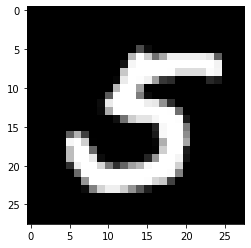

In [186]:
plt.imshow(img.reshape(28,28), cmap=plt.cm.Greys_r);

Text(0, 0.5, 'activation (ReLU)')

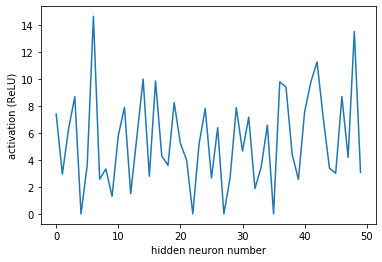

In [191]:
plt.plot(e[0])
plt.xlabel("hidden neuron number")
plt.ylabel("activation (ReLU)")

### encoder activations

or more comprehensively for a set of images. Observe we sort the images grouping all images of each class together. 

- Can you see some activation patterns for different classes?
- Is there a most active neuron per class

encoded data size (200, 50)
mean activation at encoder 6.036


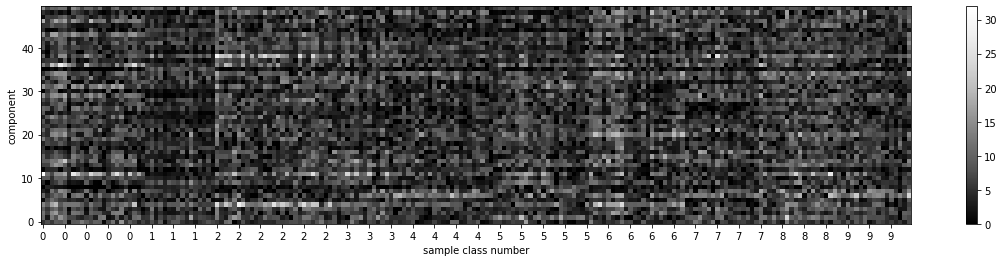

In [198]:
idxs = np.random.permutation(len(X_test))[:200]
idxs = idxs[np.argsort(y_test[idxs])]
y_sample = y_test[idxs]
X_sample = X_test[idxs]

X_sample_encoded = me([X_sample]).numpy()
print("encoded data size", X_sample_encoded.shape)
plt.figure(figsize=(20,4))
plt.imshow(X_sample_encoded.T, cmap=plt.cm.Greys_r, origin="bottom")
plt.colorbar()
plt.ylabel("component")
plt.xlabel("sample class number")
plt.xticks(range(len(y_sample))[::5], y_sample[::5]);
print ("mean activation at encoder %.3f"%np.mean(X_sample_encoded))


let's get the average activation of the neurons in the latent space for each class.

**Remember however that we trained the network WITHOUT the class information (unsupervised)**

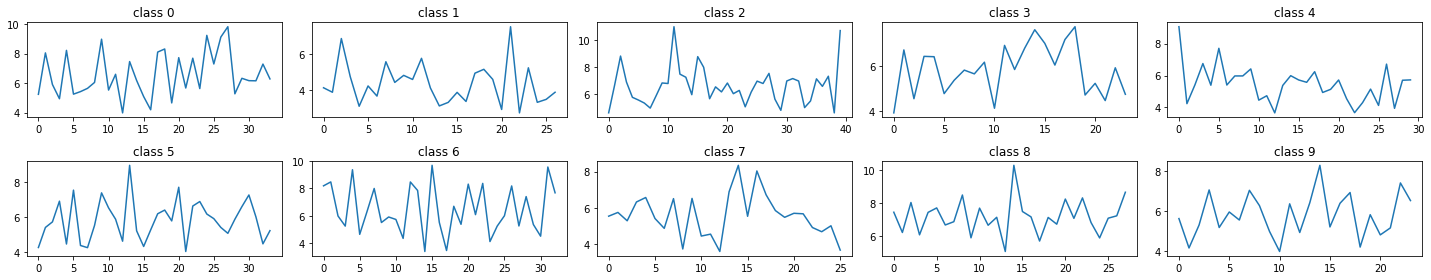

In [209]:
e = me(X_test).numpy()

plt.figure(figsize=(20,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.plot(e[y_test==i].mean(axis=1))
    plt.title(f"class {i}")
plt.tight_layout()

### observe distribution of activations at the encoder

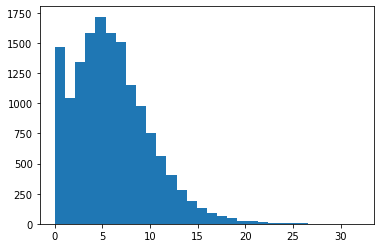

In [210]:
plt.hist(e.flatten(), bins=30);

**From this we can inspect the neuron activations in our dataset.**

for instance, we can get the average activation of the encoder neurons across all inputs

In [74]:
me(X_train).numpy().mean(axis=0)

array([6.54092  , 6.890245 , 5.0332685, 4.638923 , 4.586272 , 4.872563 ,
       4.452017 , 6.6687894, 5.845137 , 9.670084 , 5.5277524, 3.8713033,
       6.623263 , 6.4029975, 5.745097 , 6.755461 , 6.059909 , 5.918733 ,
       4.8369656, 3.787856 , 5.030886 , 4.2290273, 7.1920123, 6.9971023,
       5.206792 , 4.4348135, 4.7578964, 7.8614182, 6.2570157, 8.095148 ,
       5.5375223, 5.2380457, 5.7093854, 5.4041505, 3.3272092, 4.686344 ,
       6.4694433, 4.4688597, 6.687395 , 7.0459824, 6.1812396, 9.49828  ,
       8.421416 , 6.230216 , 4.630983 , 4.014663 , 6.3445034, 5.1579123,
       7.8651147, 5.29035  ], dtype=float32)

## 3. Custom loss, unsupervised `.fit(X)` call $\rightarrow$ MSE

given:

- $\mathbf{x}^{(i)} \in \mathbb{R}^{784}$
- $e(\mathbf{x}^{(i)}) \in \mathbb{R}^{50}$, the encoder
- $d(e(\mathbf{x}^{(i)})) \in \mathbb{R}^{784}$, the decoder

we define the loss function as (MSE):

$$\text{loss}(\mathbf{x}^{(i)}) = \frac{1}{m}\sum_m \big(\mathbf{x}^{(i)} - d(e(\mathbf{x}^{(i)}))\big)^2$$

and implement it by hand, instead of using the prebuilt implementation

In [211]:
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse
import tensorflow as tf

def get_model_U(input_dim, code_size):
    inputs = Input(shape=input_dim, name="input")
    encoder = Dense(code_size, activation='relu', name="encoder")(inputs)
    outputs = Dense(input_dim, activation='sigmoid', name="output")(encoder)

    loss = tf.reduce_mean( (inputs-outputs)**2)
    model = Model([inputs], [outputs])    
    model.add_loss(loss)
    
    model.compile(optimizer='adam')
    return model

In [212]:
model = get_model_U(input_dim=X.shape[1], code_size=40)
model.summary()

W1221 08:07:36.892163 4737162752 training_utils.py:1444] Output output missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to output.


Model: "model_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder (Dense)                 (None, 40)           31400       input[0][0]                      
__________________________________________________________________________________________________
output (Dense)                  (None, 784)          32144       encoder[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_2 (TensorFlowOp [(None, 784)]        0           input[0][0]                      
                                                                 output[0][0]              

observe `.fit` call is now unsupervised (hence, the warning above)

In [213]:
model.fit(X_train, epochs=100, batch_size=32)

Train on 1200 samples
Epoch 1/100
1200/1200 [==============================] - 0s 190us/sample - loss: 0.1415
Epoch 2/100
1200/1200 [==============================] - 0s 49us/sample - loss: 0.0702
Epoch 3/100
1200/1200 [==============================] - 0s 58us/sample - loss: 0.0635
Epoch 4/100
1200/1200 [==============================] - 0s 55us/sample - loss: 0.0572
Epoch 5/100
1200/1200 [==============================] - 0s 50us/sample - loss: 0.0519
Epoch 6/100
1200/1200 [==============================] - 0s 51us/sample - loss: 0.0475
Epoch 7/100
1200/1200 [==============================] - 0s 52us/sample - loss: 0.0442
Epoch 8/100
1200/1200 [==============================] - 0s 53us/sample - loss: 0.0418
Epoch 9/100
1200/1200 [==============================] - 0s 51us/sample - loss: 0.0398
Epoch 10/100
1200/1200 [==============================] - 0s 52us/sample - loss: 0.0381
Epoch 11/100
1200/1200 [==============================] - 0s 51us/sample - loss: 0.0364
Epoch 12/100
1200/

Epoch 94/100
1200/1200 [==============================] - 0s 37us/sample - loss: 0.0079
Epoch 95/100
1200/1200 [==============================] - 0s 42us/sample - loss: 0.0079
Epoch 96/100
1200/1200 [==============================] - 0s 41us/sample - loss: 0.0079
Epoch 97/100
1200/1200 [==============================] - 0s 39us/sample - loss: 0.0078
Epoch 98/100
1200/1200 [==============================] - 0s 39us/sample - loss: 0.0078
Epoch 99/100
1200/1200 [==============================] - 0s 38us/sample - loss: 0.0078
Epoch 100/100
1200/1200 [==============================] - 0s 36us/sample - loss: 0.0077


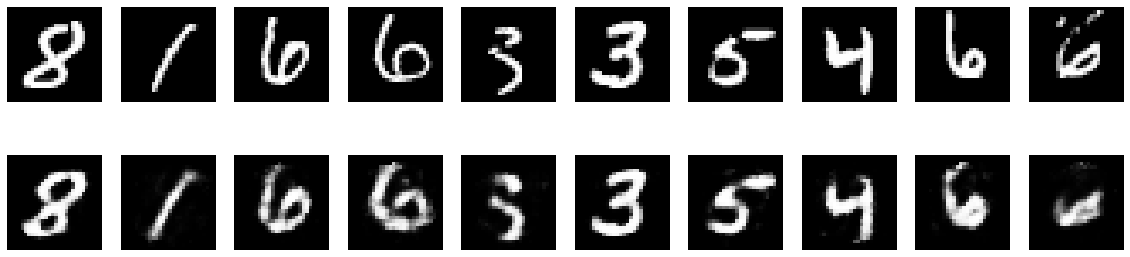

In [214]:
X_sample = np.random.permutation(X_test)[:10]
X_pred   = model.predict(X_sample)

plt.figure(figsize=(20,5))
for i in range(len(X_sample)):
    plt.subplot(2,len(X_sample),i+1)
    plt.imshow(X_sample[i].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.subplot(2,len(X_sample),len(X_sample)+i+1)
    plt.imshow(X_pred[i].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")

## 4. Autoencoder for image denoising

observe reconstruction when fed with noisy data


In [215]:
def add_noise(x, noise_level=.2):
    return x + np.random.normal(size=x.shape)*noise_level

In [216]:
X_sample = np.random.permutation(X_test)[:10]
X_pred   = model.predict(X_sample)
X_sample_noisy = add_noise(X_sample)
X_pred_noisy   = model.predict(X_sample_noisy)

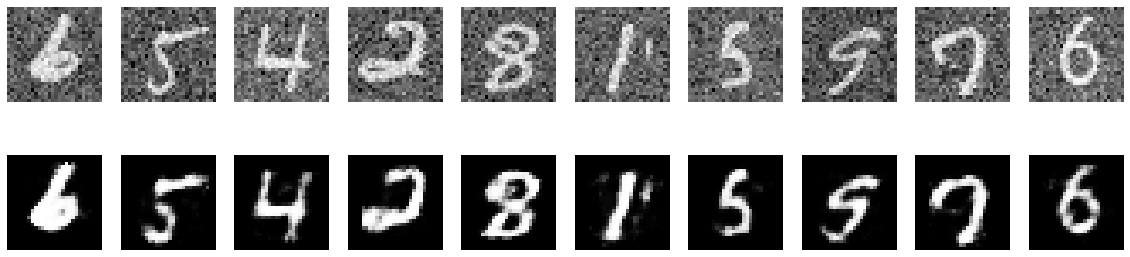

In [217]:
plt.figure(figsize=(20,5))
for i in range(len(X_sample_noisy)):
    plt.subplot(2,len(X_sample_noisy),i+1)
    plt.imshow(X_sample_noisy[i].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.subplot(2,len(X_sample_noisy),len(X_sample_noisy)+i+1)
    plt.imshow(X_pred_noisy[i].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")

### in a more real scenario we only have noisy data to train the model


In [218]:
n_model = get_model(input_dim=X.shape[1], code_size=40)
X_train_noisy = add_noise(X_train)

n_model.fit(X_train_noisy, X_train_noisy, epochs=100, batch_size=32)

Train on 1200 samples
Epoch 1/100
1200/1200 [==============================] - 0s 199us/sample - loss: 0.1847
Epoch 2/100
1200/1200 [==============================] - 0s 48us/sample - loss: 0.1102
Epoch 3/100
1200/1200 [==============================] - 0s 51us/sample - loss: 0.1042
Epoch 4/100
1200/1200 [==============================] - 0s 52us/sample - loss: 0.0972
Epoch 5/100
1200/1200 [==============================] - 0s 48us/sample - loss: 0.0917
Epoch 6/100
1200/1200 [==============================] - 0s 49us/sample - loss: 0.0872
Epoch 7/100
1200/1200 [==============================] - 0s 53us/sample - loss: 0.0836
Epoch 8/100
1200/1200 [==============================] - 0s 51us/sample - loss: 0.0808
Epoch 9/100
1200/1200 [==============================] - 0s 49us/sample - loss: 0.0786
Epoch 10/100
1200/1200 [==============================] - 0s 52us/sample - loss: 0.0766
Epoch 11/100
1200/1200 [==============================] - 0s 48us/sample - loss: 0.0747
Epoch 12/100
1200/

Epoch 94/100
1200/1200 [==============================] - 0s 38us/sample - loss: 0.0450
Epoch 95/100
1200/1200 [==============================] - 0s 37us/sample - loss: 0.0449
Epoch 96/100
1200/1200 [==============================] - 0s 39us/sample - loss: 0.0448
Epoch 97/100
1200/1200 [==============================] - 0s 41us/sample - loss: 0.0448
Epoch 98/100
1200/1200 [==============================] - 0s 38us/sample - loss: 0.0447
Epoch 99/100
1200/1200 [==============================] - 0s 36us/sample - loss: 0.0447
Epoch 100/100
1200/1200 [==============================] - 0s 36us/sample - loss: 0.0447


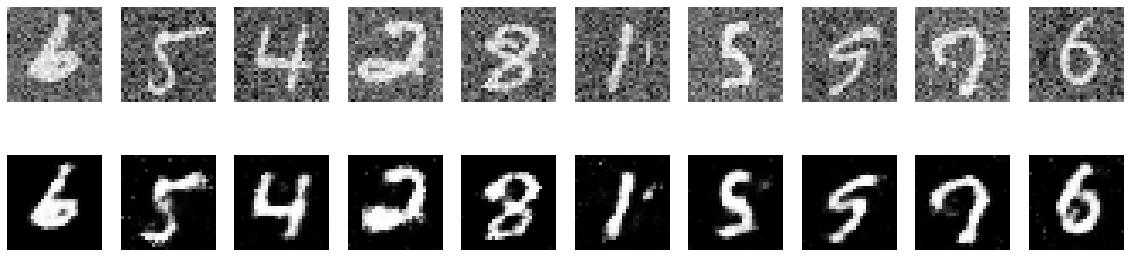

In [219]:
X_sample_noisy = add_noise(X_sample)
X_pred_noisy   = n_model.predict(X_sample_noisy)

plt.figure(figsize=(20,5))
for i in range(len(X_sample_noisy)):
    plt.subplot(2,len(X_sample_noisy),i+1)
    plt.imshow(X_sample_noisy[i].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.subplot(2,len(X_sample_noisy),len(X_sample_noisy)+i+1)
    plt.imshow(X_pred_noisy[i].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")